In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

# Import preprocessing utilities
from EDA.clean_data import clean_data

# Import the LSTM module functions
from TwoLayerLSTM import (
    TwoLayerESGModel,
    ESGTimeSeriesDataset,
    train_two_layer_model,
    evaluate_two_layer_model,
    visualize_esg_results,
    analyze_esg_predictor
)

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'data', 'energy_cleaned.csv')

df = pd.read_csv(file_path)

df = clean_data(df)

df.head()


Dataset shape: (850, 67)
Number of companies: 118
Year range: 2015 to 2023


,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Country_New Zealand,Country_Norway,Country_Poland,Country_Portugal,Country_Spain,Country_Switzerland,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.66,55.296,42.616,41.717,...,False,False,False,False,True,False,False,False,False,False
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.05,55.497,48.354,36.578,...,False,False,False,False,True,False,False,False,False,False
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.11,57.248,50.317,44.891,...,False,False,False,False,True,False,False,False,False,False
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.64,62.609,52.280,59.039,...,False,False,False,False,True,False,False,False,False,False
5,ACS Actividades de Construccion y Servicios SA,ACS,2019,2.79,1.31,4.21,3.87,64.390,57.626,59.039,...,False,False,False,False,True,False,False,False,False,False


In [4]:
# Define target columns in the proper order:
# 1. Main ESG Score first
# 2. Pillar scores
# 3. Disclosure scores
target_cols = [
    'BESG ESG Score',                # Main ESG Score - the ultimate target
    'BESG Environmental Pillar Score', # Component: Environmental Pillar
    'BESG Social Pillar Score',        # Component: Social Pillar
    'BESG Governance Pillar Score',    # Component: Governance Pillar
    'ESG Disclosure Score',            # Component: Overall ESG Disclosure
    'Environmental Disclosure Score',  # Component: Environmental Disclosure
    'Social Disclosure Score',         # Component: Social Disclosure
    'Governance Disclosure Score'      # Component: Governance Disclosure
]

In [5]:
# First, verify the correlation between the components and the ESG score
component_cols = target_cols[1:]
corr_df = df[target_cols].corr()

print("\nCorrelation of component scores with ESG Score:")
print(corr_df['BESG ESG Score'].sort_values(ascending=False))


Correlation of component scores with ESG Score:
BESG ESG Score                     1.000000
BESG Environmental Pillar Score    0.918117
ESG Disclosure Score               0.801137
BESG Social Pillar Score           0.739926
Environmental Disclosure Score     0.706130
Social Disclosure Score            0.696146
Governance Disclosure Score        0.490789
BESG Governance Pillar Score       0.464822
Name: BESG ESG Score, dtype: float64


In [6]:
# Create a multiple regression to verify R² between components and ESG score
X_reg = df[component_cols]
y_reg = df['BESG ESG Score']

reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)
y_pred = reg_model.predict(X_reg)

r2 = r2_score(y_reg, y_pred)
print(f"\nR² of linear regression from components to ESG score: {r2:.6f}")

print("\nRegression coefficients:")
for component, coef in zip(component_cols, reg_model.coef_):
    print(f"{component}: {coef:.6f}")
print(f"Intercept: {reg_model.intercept_:.6f}")



R² of linear regression from components to ESG score: 0.993430

Regression coefficients:
BESG Environmental Pillar Score: 0.483065
BESG Social Pillar Score: 0.291660
BESG Governance Pillar Score: 0.237175
ESG Disclosure Score: 1.546196
Environmental Disclosure Score: -0.515209
Social Disclosure Score: -0.514080
Governance Disclosure Score: -0.515832
Intercept: -0.119616


In [ ]:
# Train the two-layer model
model, train_loader, test_loader, test_dataset, feature_names, history, device, component_cols = train_two_layer_model(
    df,
    target_cols,
    hidden_size=128,         # Size of LSTM hidden layers
    num_layers=3,            # Number of LSTM layers
    seq_length=3,            # Number of time steps to look back
    learning_rate=0.01,     # Learning rate for optimizer
    train_size=0.8,          # Proportion of companies to use for training
    epochs=1000,              # Maximum number of training epochs
    patience=50,             # Early stopping patience
    batch_size=32,           # Batch size for training
    initial_component_weight=0.9,
    threshold=30,
)

Using device: cpu
Training model...
Epoch 5/1000 | Train Loss: 1835.7723 | Val Loss: 2007.4210 | ESG Loss: 8.1708 | Component Loss: 2038.8392 | Component Weight: 0.9000
Epoch 10/1000 | Train Loss: 1679.8785 | Val Loss: 1798.7029 | ESG Loss: 6.2319 | Component Loss: 1865.8393 | Component Weight: 0.9000
Epoch 15/1000 | Train Loss: 1526.9702 | Val Loss: 1646.1565 | ESG Loss: 5.2596 | Component Loss: 1696.0492 | Component Weight: 0.9000
Epoch 20/1000 | Train Loss: 1346.4481 | Val Loss: 1443.9896 | ESG Loss: 2.8621 | Component Loss: 1495.7355 | Component Weight: 0.9000
Epoch 25/1000 | Train Loss: 1152.1387 | Val Loss: 1238.7928 | ESG Loss: 2.0880 | Component Loss: 1279.9222 | Component Weight: 0.9000
Epoch 30/1000 | Train Loss: 914.5409 | Val Loss: 1041.6151 | ESG Loss: 1.5378 | Component Loss: 1015.9858 | Component Weight: 0.9000
Epoch 35/1000 | Train Loss: 683.3235 | Val Loss: 795.4926 | ESG Loss: 1.2141 | Component Loss: 759.1135 | Component Weight: 0.9000
Epoch 40/1000 | Train Loss: 437

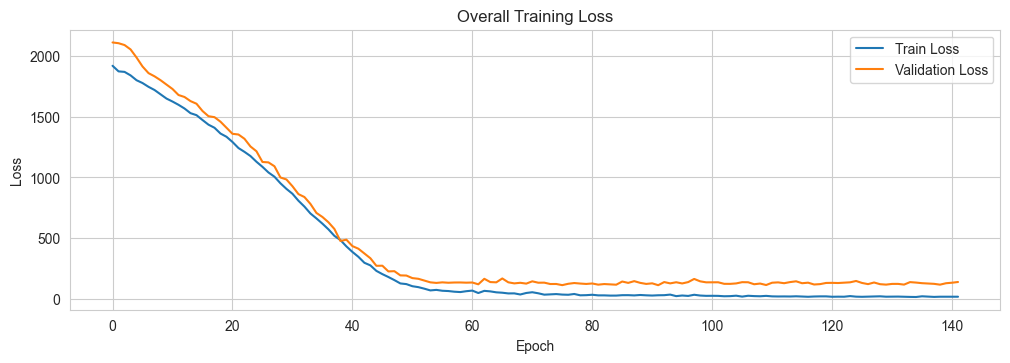

In [19]:
# Plot training history
plt.figure(figsize=(12, 8))

# Plot overall loss
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overall Training Loss')
plt.legend()
plt.grid(True)

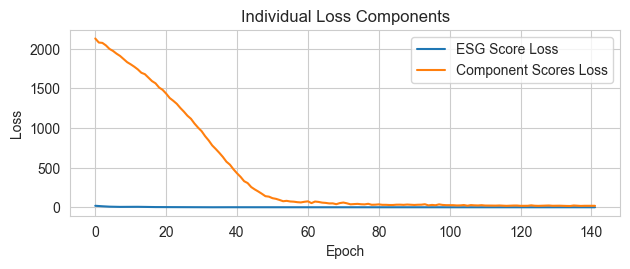

In [20]:
# Plot component losses
plt.subplot(2, 1, 2)
plt.plot(history['esg_loss'], label='ESG Score Loss')
plt.plot(history['component_loss'], label='Component Scores Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Individual Loss Components')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Evaluate the model
results = evaluate_two_layer_model(model, test_loader, device, component_cols)

# Print ESG score metrics
print("\nESG Score Prediction Metrics:")
print(f"MSE: {results['esg']['mse']:.6f}")
print(f"RMSE: {results['esg']['rmse']:.6f}")
print(f"MAE: {results['esg']['mae']:.6f}")
print(f"R²: {results['esg']['r2']:.6f}")

# Print average component metrics
print("\nAverage Component Score Metrics:")
print(f"MSE: {results['components']['avg_mse']:.6f}")
print(f"RMSE: {results['components']['avg_rmse']:.6f}")
print(f"MAE: {results['components']['avg_mae']:.6f}")
print(f"R²: {results['components']['avg_r2']:.6f}")


ESG Score Prediction Metrics:
MSE: 1.351085
RMSE: 1.162362
MAE: 0.918155
R²: 0.214834

Average Component Score Metrics:
MSE: 124.214786
RMSE: 8.831858
MAE: 7.004172
R²: 0.113093


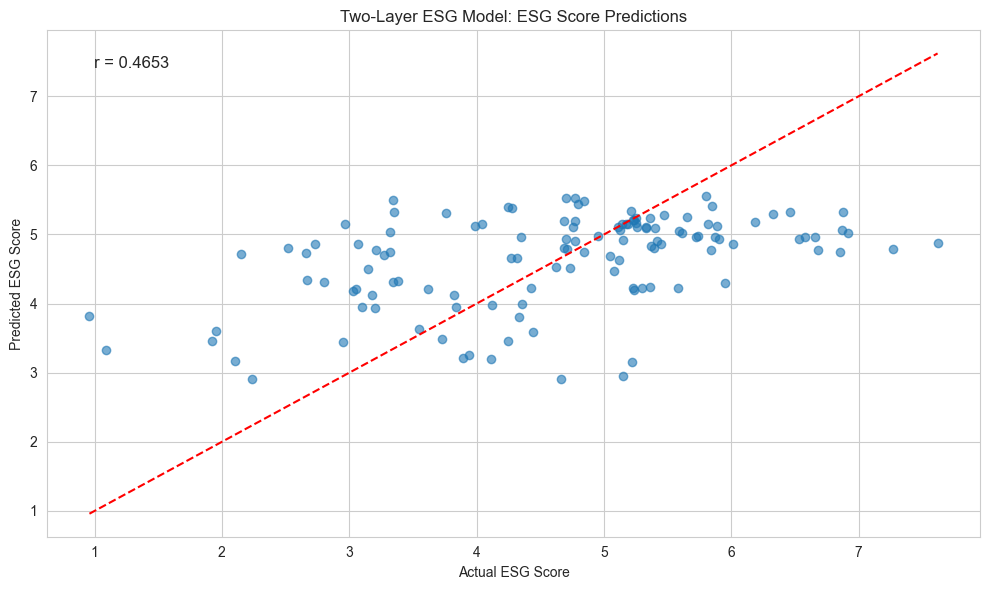

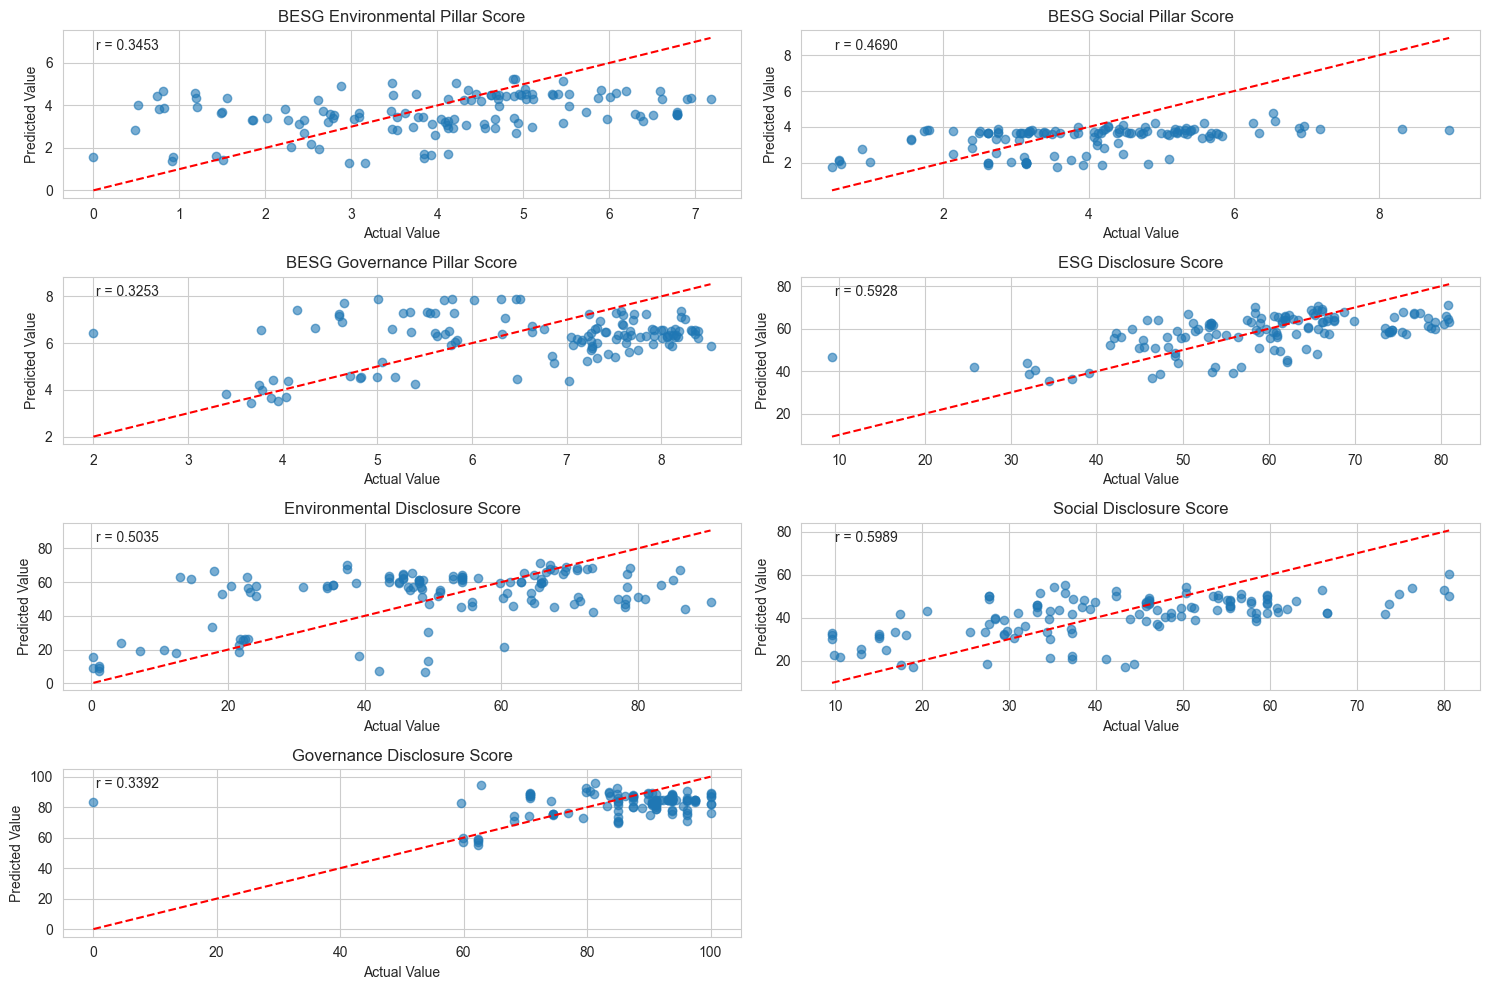


Model Performance Metrics:


,mse,rmse,mae,r2
component,,,,
BESG Environmental Pillar Score,2.862556,1.691909,1.353364,0.035133
BESG Social Pillar Score,2.318506,1.522664,1.260074,0.051731
BESG Governance Pillar Score,2.370566,1.539664,1.316961,-0.109803
ESG Disclosure Score,110.056625,10.490788,8.479428,0.334832
Environmental Disclosure Score,395.795868,19.894619,15.624710,0.177341
Social Disclosure Score,183.971756,13.563619,11.344794,0.349160
Governance Disclosure Score,172.127625,13.119742,9.649876,-0.046741
ESG Score,1.351085,1.162362,0.918155,0.214834
Avg Component,124.214786,8.831858,7.004172,0.113093


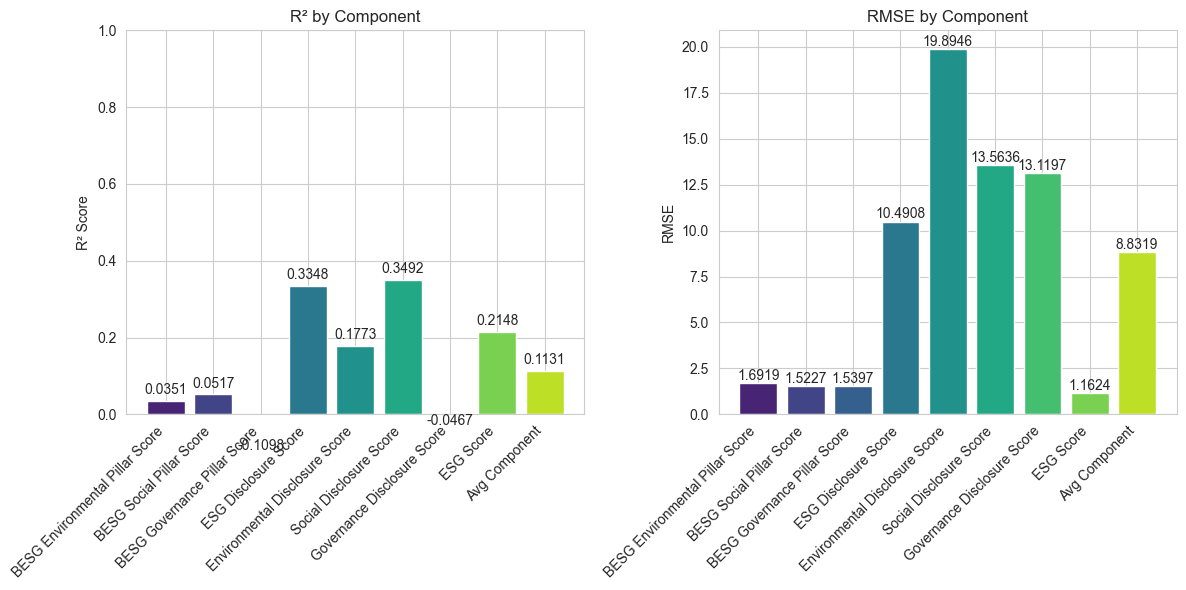

In [22]:
# Visualize results
metrics_df = visualize_esg_results(results, component_cols)

In [23]:
# Analyze the ESG predictor (second layer) weights
weights, bias = analyze_esg_predictor(model)

# Display the weights and bias
print("\nESG Predictor Weights (Second Layer):")
for i, component in enumerate(component_cols):
    print(f"{component}: {weights[0, i]:.6f}")
print(f"Bias: {bias[0]:.6f}")


ESG Predictor Weights (Second Layer):
BESG Environmental Pillar Score: 0.093692
BESG Social Pillar Score: 0.096925
BESG Governance Pillar Score: 0.082787
ESG Disclosure Score: 0.017585
Environmental Disclosure Score: 0.013007
Social Disclosure Score: 0.016201
Governance Disclosure Score: 0.011844
Bias: 0.137285


In [24]:
# Compare with the linear regression model
print("\nComparison of ESG predictor weights with linear regression:")
comparison = pd.DataFrame({
    'Component': component_cols,
    'LSTM Layer Weight': weights[0],
    'Linear Regression': reg_model.coef_
})
comparison['Difference'] = comparison['LSTM Layer Weight'] - comparison['Linear Regression']
print(comparison)

# Also compare the bias terms
print(f"\nBias - LSTM Layer: {bias[0]:.6f}, Linear Regression: {reg_model.intercept_:.6f}")
print(f"Difference: {bias[0] - reg_model.intercept_:.6f}")

# Explain the model architecture
print("\nTwo-Layer ESG Model Architecture:")
print("1. First Layer: Bidirectional LSTM with attention mechanism")
print("   - Processes sequential company data over time")
print("   - Predicts the 7 component scores (Pillar and Disclosure scores)")
print("2. Second Layer: Linear regression")
print("   - Takes the 7 component scores as input")
print("   - Predicts the final ESG score")
print("\nThe model is trained with a custom loss function that:")
print(f"- Places {(1-0.2)*100:.0f}% weight on ESG score prediction accuracy")
print(f"- Places {0.2*100:.0f}% weight on component score prediction accuracy")


Comparison of ESG predictor weights with linear regression:
                         Component  LSTM Layer Weight  Linear Regression  \
0  BESG Environmental Pillar Score           0.093692           0.483065   
1         BESG Social Pillar Score           0.096925           0.291660   
2     BESG Governance Pillar Score           0.082787           0.237175   
3             ESG Disclosure Score           0.017585           1.546196   
4   Environmental Disclosure Score           0.013007          -0.515209   
5          Social Disclosure Score           0.016201          -0.514080   
6      Governance Disclosure Score           0.011844          -0.515832   

   Difference  
0   -0.389373  
1   -0.194734  
2   -0.154388  
3   -1.528611  
4    0.528217  
5    0.530281  
6    0.527676  

Bias - LSTM Layer: 0.137285, Linear Regression: -0.119616
Difference: 0.256901

Two-Layer ESG Model Architecture:
1. First Layer: Bidirectional LSTM with attention mechanism
   - Processes sequential c

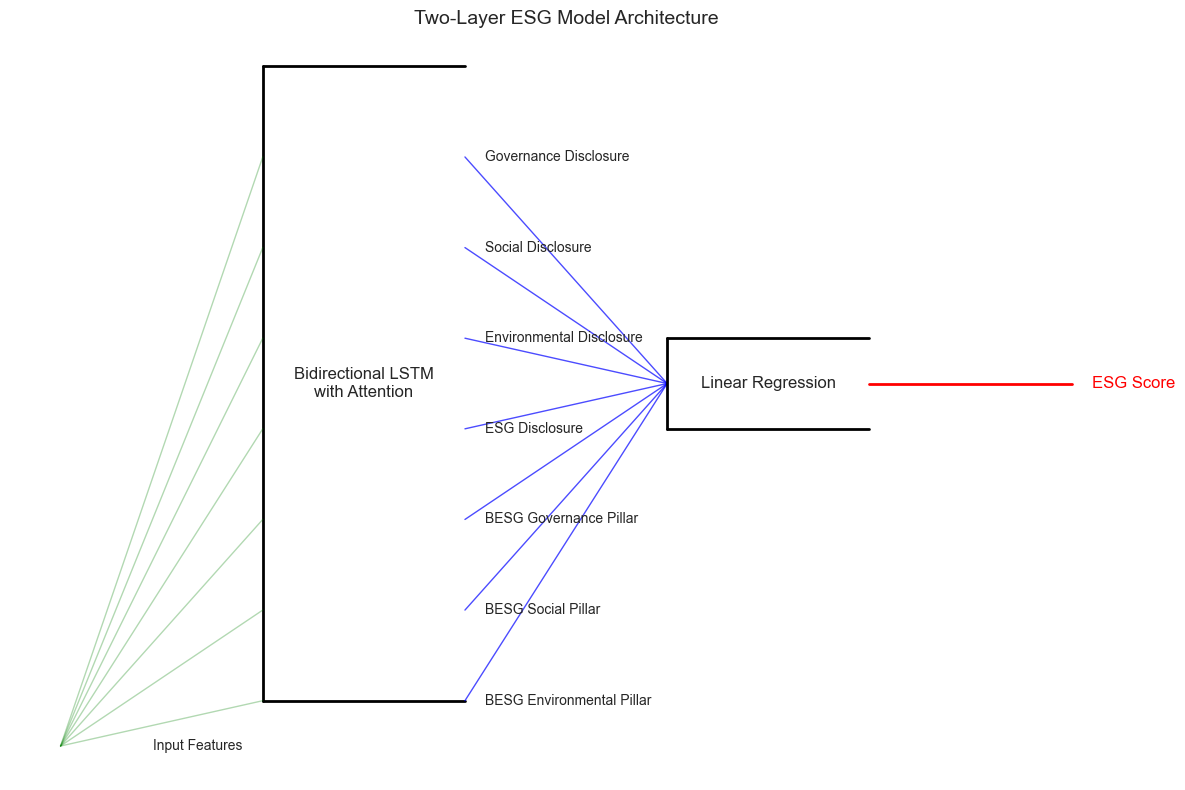

In [14]:
# Visualize the architecture
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)

# LSTM layer representation
plt.plot([0, 0], [0, 7], 'k-', linewidth=2)
plt.plot([0, 2], [0, 0], 'k-', linewidth=2)
plt.plot([0, 2], [7, 7], 'k-', linewidth=2)
plt.text(1, 3.5, "Bidirectional LSTM\nwith Attention", ha='center', va='center', fontsize=12)

# Component scores representation
for i, component in enumerate(component_cols):
    plt.plot([2, 4], [i, 3.5], 'b-', linewidth=1, alpha=0.7)
    plt.text(2.2, i, component.replace(" Score", ""), fontsize=10, ha='left', va='center')

# ESG predictor representation
plt.plot([4, 4], [3, 4], 'k-', linewidth=2)
plt.plot([4, 6], [3, 3], 'k-', linewidth=2)
plt.plot([4, 6], [4, 4], 'k-', linewidth=2)
plt.text(5, 3.5, "Linear Regression", ha='center', va='center', fontsize=12)

# ESG score representation
plt.plot([6, 8], [3.5, 3.5], 'r-', linewidth=2)
plt.text(8.2, 3.5, "ESG Score", fontsize=12, ha='left', va='center', color='r')

# Input features representation
plt.text(-0.2, -0.5, "Input Features", fontsize=10, ha='right', va='center')
for i in range(7):
    plt.plot([-2, 0], [-0.5, i], 'g-', linewidth=1, alpha=0.3)

plt.axis('off')
plt.title('Two-Layer ESG Model Architecture', fontsize=14)
plt.tight_layout()
plt.savefig('model_architecture.png', dpi=300, bbox_inches='tight')
plt.show()


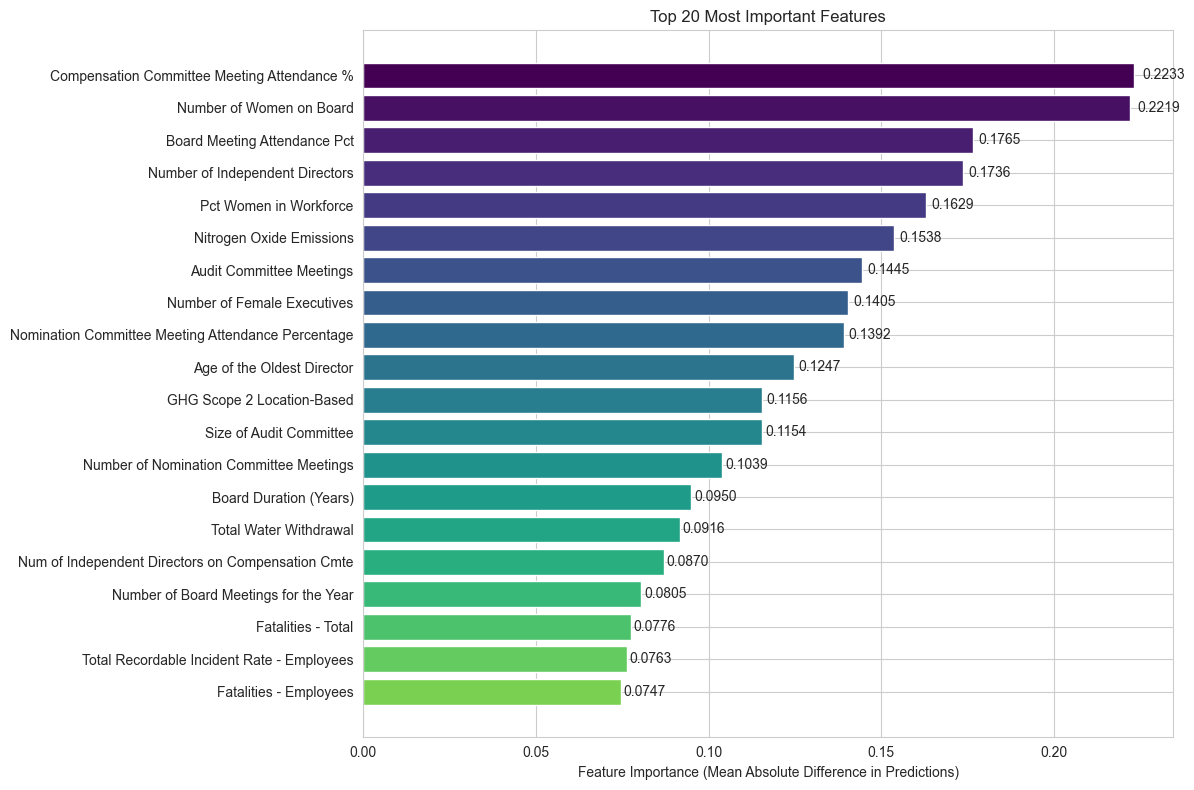

In [ ]:
# Analyze the feature importance based on gradient-based approaches
def analyze_feature_importance(model, test_dataset, feature_names, device, n_samples=50):
    """
    Analyze feature importance using input perturbation
    """
    model.to(device)
    model.eval()

    # Get a subset of test data
    from torch.utils.data import DataLoader, Subset

    # Create a subset of the test dataset
    subset_indices = np.random.choice(len(test_dataset), min(n_samples, len(test_dataset)), replace=False)
    subset = Subset(test_dataset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

    # Calculate baseline predictions
    baseline_preds = []

    with torch.no_grad():
        for batch in subset_loader:
            features = batch['features'].to(device)
            _, _, esg_pred = model(features)
            baseline_preds.append(esg_pred.cpu().numpy())

    baseline_preds = np.concatenate(baseline_preds)

    # Calculate importance for each feature
    importances = {}

    for feat_idx, feature_name in enumerate(feature_names):
        # Reset loader
        subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

        # Permute the feature and calculate new predictions
        permuted_preds = []

        with torch.no_grad():
            for batch in subset_loader:
                features = batch['features'].clone().to(device)

                # Permute this feature across the sequence
                for seq_idx in range(features.size(1)):
                    # Zero out this feature (setting it to the mean, which is 0 after standardization)
                    features[0, seq_idx, feat_idx] = 0

                _, _, esg_pred = model(features)
                permuted_preds.append(esg_pred.cpu().numpy())

        permuted_preds = np.concatenate(permuted_preds)

        # Importance is the mean absolute difference in predictions
        importance = np.mean(np.abs(baseline_preds - permuted_preds))
        importances[feature_name] = importance

    # Sort by importance
    importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}

    return importances

# Get feature importance
feature_importances = analyze_feature_importance(model, test_dataset, feature_names, device, n_samples=50)

# Plot feature importance
plt.figure(figsize=(12, 8))

# Get top 20 features
top_n = 20
top_features = list(feature_importances.keys())[:top_n]
top_values = [feature_importances[f] for f in top_features]

# Create plot
bars = plt.barh(range(len(top_features)), top_values, color=plt.cm.viridis(np.linspace(0, 0.8, len(top_features))))

# Add feature names
plt.yticks(range(len(top_features)), top_features)

# Add values to bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width * 1.01, i, f'{width:.4f}', ha='left', va='center')

plt.xlabel('Feature Importance (Mean Absolute Difference in Predictions)')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Display the most important at the top
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Print top 10 most important features
print("\nTop 10 most important features:")
for i, (feature, importance) in enumerate(list(feature_importances.items())[:10]):
    print(f"{i+1}. {feature}: {importance:.6f}")



Top 10 most important features:
1. Compensation Committee Meeting Attendance %: 0.223286
2. Number of Women on Board: 0.221943
3. Board Meeting Attendance Pct: 0.176506
4. Number of Independent Directors: 0.173584
5. Pct Women in Workforce: 0.162861
6. Nitrogen Oxide Emissions: 0.153756
7. Audit Committee Meetings: 0.144467
8. Number of Female Executives: 0.140469
9. Nomination Committee Meeting Attendance Percentage: 0.139154
10. Age of the Oldest Director: 0.124731
